In [4]:
import re
import emoji
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from collections import Counter

In [1]:
file_location = 'WhatsApp Chat with NMS 04.txt'

In [2]:
#read text from file
with open(file_location, 'r', encoding = 'utf-8') as f:
    data=f.read()
    data = ' '.join(data.split('\n'))

In [5]:
#match and datetime pattern and seperate messages from the dates
pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'
user_messages = re.split(pattern, data)[1:] #get message text
message_dates = re.findall(pattern, data) #get timestamp

In [6]:
pattern

'\\d{1,2}/\\d{1,2}/\\d{2,4},\\s\\d{1,2}:\\d{2}\\s-\\s'

In [7]:
#load user messages and dates into a dataframe
df= pd.DataFrame({'user_message' :user_messages, 'message_date':message_dates})

In [8]:
df.head() #take a look at the first five rows of the dataframe

,user_message,message_date
0,+234 808 371 9915: Lol,"3/3/21, 12:47 -"
1,Dennis: 2021 Niger Delta Postgraduate Scholars...,"3/3/21, 13:38 -"
2,Dennis: <Media omitted>,"3/3/21, 13:58 -"
3,Iroka: Something about this is that even the o...,"3/3/21, 14:05 -"
4,Mai chin chin: 😂🤣,"3/3/21, 14:08 -"


In [9]:
#clean the message_date column
df['message_date'] = df['message_date'].str.split(' -', 1).str[0]

C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2943662718.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['message_date'] = df['message_date'].str.split(' -', 1).str[0]


In [10]:
#convert message_date type to a datetime object
df['message_date'] = pd.to_datetime(df['message_date'], format='%m/%d/%y, %H:%M')

In [11]:
#rename the date column
df.rename(columns={'message_date': 'date'}, inplace=True)

In [12]:
#create seperate placeholder objects for users and messages
users = []
messages = []

In [13]:
#preprocessing to seperate the username from the messages
for message in df['user_message']:
    entry = re.split('([\w\W]+?):\s', message)
    if entry[1:]:#user name
        users.append(entry[1])
        messages.append(entry[2])
    else:
        users.append('group_notification')
        messages.append(entry[0])
            
            

In [14]:
#create new columns that for the dataframe from the splits
df['user'] = users
df['message']=messages
df.drop(columns=['user_message'], inplace=True)

df.tail()

,date,user,message
39994,2023-05-21 10:31:00,Chimka Eke Blondu,Which kind wahala be dis
39995,2023-05-21 10:31:00,+234 806 786 5764,"They are actually having fun😊, b4 Snr boy go s..."
39996,2023-05-21 10:33:00,Thomas Akpaka,😂😂😂
39997,2023-05-21 11:28:00,Chimka Eke Blondu,Elder see me o 😀
39998,2023-05-21 16:40:00,+234 802 878 6903,Even dis ones go pay tio


In [58]:
Number_of_group_members = len(df.user.unique())

In [60]:
print(f'There are {Number_of_group_members} members in this group')

There are 161 members in this group


#  Number of Images and videos shared in the group

In [15]:
#clean the data 
#1. remove all the <Media omitted> messages

images = df[df['message']=='<Media omitted> ']
print('Total number of Images + Videos shared:', len(images))
df.drop(images.index, inplace=True)

Total number of Images + Videos shared: 5637


In [16]:
#remove all group notifications
notifications = df[df['user']== 'group_notification']
print('Total Group Notifications:', len(notifications))
df.drop(notifications.index, inplace=True)

Total Group Notifications: 678


# Anonymize the group members for privacy

In [88]:
# Create a dictionary mapping the original names to new names
unique_users = df['user'].unique()
anonymized_names = {original_name: f'User{i}' for i, original_name in enumerate(unique_users, 1)}

# Replace the names in the DataFrame
df['user'] = df['user'].replace(anonymized_names)


In [17]:
#reset the index
df.reset_index(inplace=True, drop=True)
df.tail()

,date,user,message
33679,2023-05-21 10:31:00,Chimka Eke Blondu,Which kind wahala be dis
33680,2023-05-21 10:31:00,+234 806 786 5764,"They are actually having fun😊, b4 Snr boy go s..."
33681,2023-05-21 10:33:00,Thomas Akpaka,😂😂😂
33682,2023-05-21 11:28:00,Chimka Eke Blondu,Elder see me o 😀
33683,2023-05-21 16:40:00,+234 802 878 6903,Even dis ones go pay tio


#  Most active users in the group

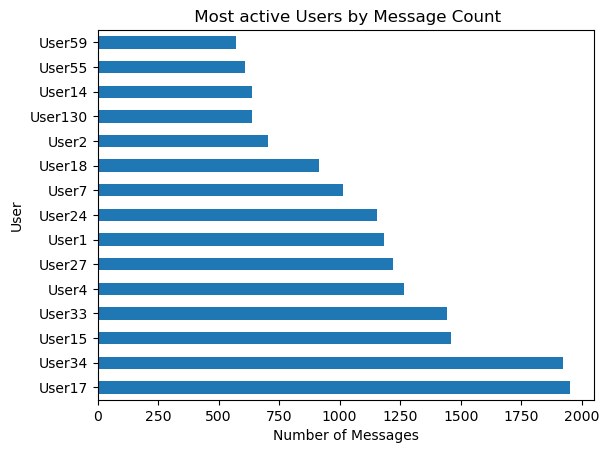

In [89]:
import matplotlib.pyplot as plt

top_15_users = df.groupby('user')['message'].count().sort_values(ascending=False).head(15)

# Create the bar chart
ax = top_15_users.plot(kind='barh')

# Set axis labels
ax.set_xlabel('Number of Messages')
ax.set_ylabel('User')

# Set chart title
ax.set_title(' Most active Users by Message Count')

# Display the chart
plt.show()


# Frequently used emojis in the group

In [69]:


emoji_counter = Counter()

r = re.compile(r'[\U0001F300-\U0001F64F]|\U0001F9E0|\U0001F9C0|\U0001F600-\U0001F636|\U0001F900-\U0001F9FF]|[\u2000-\u206F]|[\u2300-\u23FF]|[\u25A0-\u25FF]|[\u2600-\u26FF]|[\u2700-\u27BF]|\u2B00-\u2BFF|[\u2C00-\u2C5F]|[\u2D00-\u2D2F]|[\u2E00-\u2E7F]|\u3000-\u303F|\uFE00-\uFE0F|\uFE80-\uFEFF|\U0001F900-\U0001F9FF|\U0001F1E0-\U0001F1FF')

for index, row in df.iterrows():
    emojis_found = r.findall(row['message'])
    for emoji_f in emojis_found:
        emoji_counter[emoji_f] += 1

for item in emoji_counter.most_common(10):
    print(f'{item[0]} = {item[1]}')


​ = 3986
😂 = 2969
’ = 1701
💙 = 817
🙏 = 691
‍ = 637
… = 636
🏾 = 587
♂ = 567
🙄 = 475


#  Sleep Cycle/Active periods in the group

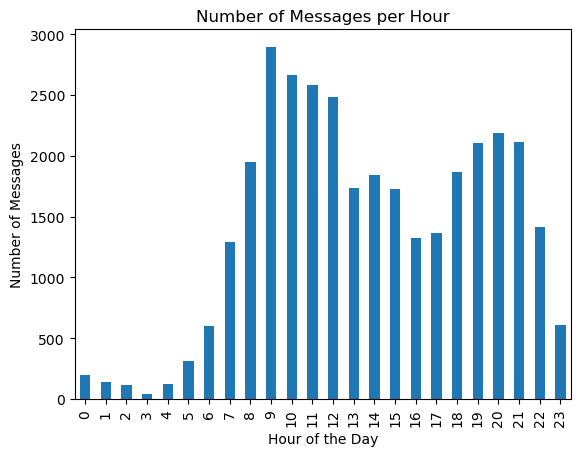

In [68]:

df['hour'] = df['date'].apply(lambda x: x.hour)
df.groupby(['hour']).size().sort_index().plot(x='hour', kind='bar')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.title('Number of Messages per Hour')

plt.show()

#  Word Cloud

In [85]:
all_words = ' '

stopwords = STOPWORDS.update(['one','even','use','well','way','deleted','may','come','will','na', 'dey', 'wey', 'go', 'make', 'sha', 'now', 'u', 'una'])

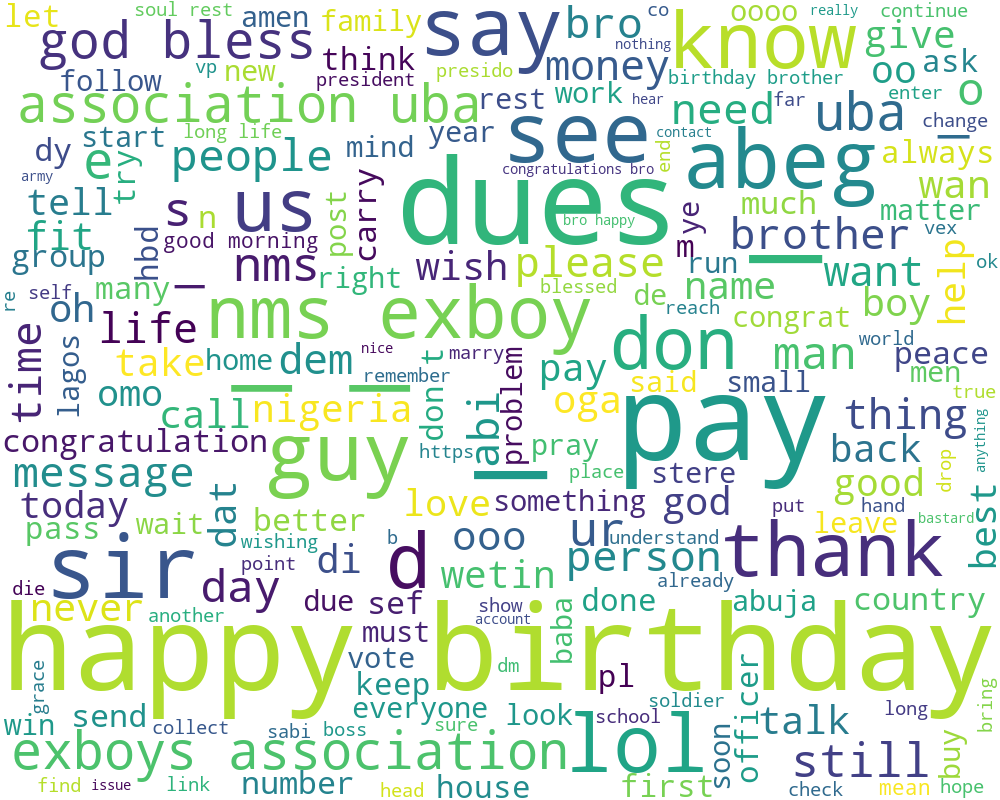

In [86]:
#build the word cloud
for msg in df['message'].values:
    words = str(msg).lower().split()
    for word in words:
        all_words = all_words + word + ' '
        
wordcloud = WordCloud(width = 1000, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(all_words)

wordcloud.to_image()

In [45]:


nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Sentiment score 

In [72]:


# Create a sentiment analyzer object
sid = SentimentIntensityAnalyzer()

# Iterate over the messages and calculate sentiment scores
sentiment_scores = []
for index, row in df.iterrows():
    message = row['message']
    sentiment_scores.append(sid.polarity_scores(message)['compound'])

# Calculate the average sentiment score
average_sentiment = sum(sentiment_scores) / len(sentiment_scores)

# Print the average sentiment score
print(f"Average Sentiment Score: {average_sentiment}")


Average Sentiment Score: 0.12646636682104176


# Most active users by number of days active

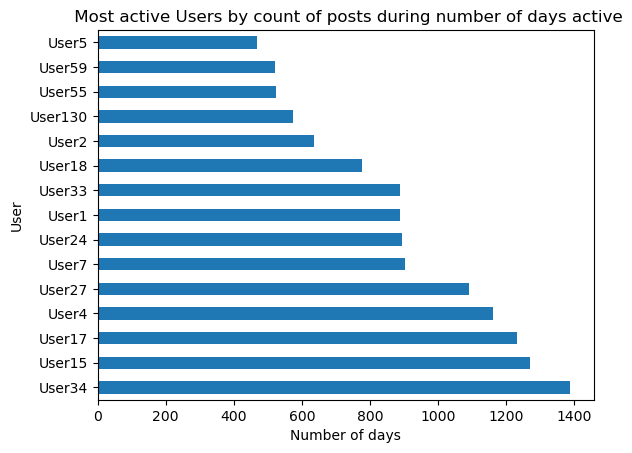

In [90]:
#users by number of active days i.e number of different day each user sent a message
active_days = df.groupby('user')['date'].nunique().sort_values(ascending=False).head(15);
ax = active_days.plot(kind='barh')

# Set axis labels
ax.set_xlabel('Number of days')
ax.set_ylabel('User')

# Set chart title
ax.set_title(' Most active Users by count of posts during number of days active')

# Display the chart
plt.show()

